# Evaluation Plots

This notebook contains the profile, maps and ENSO plots that are present in the paper

### Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from xarrayutils.plotting import linear_piecewise_scale
from dask.diagnostics import ProgressBar
from datetime import datetime

In [2]:
import sys
sys.path.append("../samudra/")

### Data

In [3]:
##### Paths
path_to_thermo_pred = "3D_thermo_all_prediction.zarr"
path_to_thermo_dynamic_pred = "3D_thermo_dynamic_all_prediction.zarr"
start_index = 2903 # Hardcoded default start index for predictions
N_test = 600 # Rollout length

pred_dict = {
    "pred_1": {
        "mode": "thermo",
        "name": "Thermo",
        "path": path_to_thermo_pred
    },
    "pred_2": {
        "mode": "thermo_dynamic",
        "name": "Thermo+Dynamic",
        "path": path_to_thermo_dynamic_pred
    }
}

prefix_path="HFDS_HFDS_Anom"

clist = ["#ff807a","#1e8685","#ffb579","#63c8ab"]
levels = 19

In [4]:
import os
import json
import pandas as pd
import copy
from utils import convert_train_data

# url_data = "zip:///::https://huggingface.co/datasets/M2LInES/Samudra_OM4/resolve/main/OM4.zip"
# data = xr.open_dataset(url_data, engine='zarr', chunks={})
data = xr.open_zarr('/pscratch/sd/s/suryad/data/3D_data_OM4_5daily_v0.2.1_with_hfds_anom_1975') # Need to read from huggingface

ds_groundtruth = data.isel(time=slice(start_index, start_index+N_test))
ds_groundtruth = convert_train_data(ds_groundtruth)


output_path = "../outputs/" + str(datetime.now())[:10] + '_' + prefix_path + '_' + '_'.join([pred_dict[k]["name"] for k in pred_dict.keys()])
print("Using Output Folder : ", output_path)
if not os.path.isdir(os.path.join(output_path)):
    os.makedirs(os.path.join(output_path))
    
compare_info_dict = copy.deepcopy(pred_dict)
    
for k in pred_dict.keys():
    if pred_dict[k]['mode'] == 'thermo':
        pred_dict[k]["ls"] = ['thetao', 'so', 'zos']
    else:
        pred_dict[k]["ls"] = ['uo', 'vo', 'thetao', 'so', 'zos']

    Pred_path = pred_dict[k]['path']
    ds_prediction = xr.open_zarr(Pred_path)
    pred_dict[k]["ds_prediction"] = ds_prediction
        
with open(os.path.join(output_path, 'compare_info.txt'), 'w') as f:
    f.write(json.dumps(compare_info_dict, sort_keys=True, indent=4))

Using Output Folder :  ../outputs/2024-12-01_HFDS_HFDS_Anom_Thermo_Thermo+Dynamic


In [5]:
%matplotlib inline

In [6]:
def profile_mean(ds: xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello).mean(["x", "y"])

In [7]:
with ProgressBar():
    print("Ground truth OM4")
    ds_groundtruth = ds_groundtruth.assign(KE=0.5 * (ds_groundtruth.uo ** 2 + ds_groundtruth.vo ** 2)*1020)
    profile_groundtruth = profile_mean(ds_groundtruth).load()
    
    for k in pred_dict.keys():
        print(k)
        if 'uo' in pred_dict[k]["ls"]:
            pred_dict[k]["ds_prediction"] = pred_dict[k]["ds_prediction"].assign(KE=0.5 * (pred_dict[k]["ds_prediction"].uo ** 2 + pred_dict[k]["ds_prediction"].vo ** 2)*1020)
            pred_dict[k]["ls"].append('KE')
        pred_dict[k]["profile_prediction"] = profile_mean(pred_dict[k]["ds_prediction"]).load()

Ground truth OM4
[########################################] | 100% Completed | 392.09 s
pred_1
[########################################] | 100% Completed | 2.33 sms
pred_2
[########################################] | 100% Completed | 5.70 sms


In [8]:
var_list = {
        "vo": r"$v$ $( m/s )$",
        "uo": r"$u$ $( m/s )$",
        "thetao": r"$T$ $( ^\circ C )$",
        "so": r"$so$ $( psu )$",
        "zos": r"$zos$ $( m )$",
        "KE": r"$KE$ $( J/m^2 )$",
    }

### Plots

In [9]:
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
import matplotlib.pyplot as plt
import regionmask
from xmip.regionmask import merged_mask
import cartopy.crs as ccrs
import os
import pandas as pd

In [10]:
# %matplotlib inline
plt.rcParams.update({'font.size': 14})

In [11]:
data = ds_groundtruth
data = data.drop_vars(['lon','lat'])
data = data.transpose('time','lev',...)
for k in pred_dict.keys():
    pred_dict[k]["ds_prediction"] = pred_dict[k]["ds_prediction"].transpose('time','lev',...)

In [12]:
for k in pred_dict.keys():
    pred_dict[k]["ds_prediction"]['y'] = pred_dict[k]["ds_prediction"].y.assign_attrs(long_name='latitude')
    pred_dict[k]["ds_prediction"]['x']  = pred_dict[k]["ds_prediction"].x.assign_attrs(long_name='longitude')
    pred_dict[k]["ds_prediction"]['thetao'] = pred_dict[k]["ds_prediction"]['thetao'].assign_attrs(long_name = r"${\theta_O}$", units = r'$\degree C$')
    pred_dict[k]["ds_prediction"]['lev'] = pred_dict[k]["ds_prediction"]['lev'].assign_attrs(long_name = 'depth', units = 'm')
    if 'so' in pred_dict[k]["ls"]:
        pred_dict[k]["ds_prediction"]['so'] = pred_dict[k]["ds_prediction"]['so'].assign_attrs(long_name = r"${s}$", units = r"psu")
    if 'zos' in pred_dict[k]["ls"]:
        pred_dict[k]["ds_prediction"]['zos'] = pred_dict[k]["ds_prediction"]['zos'].assign_attrs(long_name = r"SSH", units = r"m")    
    if 'uo' in pred_dict[k]["ls"]:
        pred_dict[k]["ds_prediction"]['vo'] = pred_dict[k]["ds_prediction"]['vo'].assign_attrs(long_name = r"${v}$", units = r"m/s")
        pred_dict[k]["ds_prediction"]['uo'] = pred_dict[k]["ds_prediction"]['uo'].assign_attrs(long_name = r"${u}$", units = r"m/s")

data['y']  = data.y.assign_attrs(long_name='latitude')
data['x']  = data.x.assign_attrs(long_name='longitude')
data['thetao'] = data['thetao'].assign_attrs(long_name = r"${\theta_O}$", units = r'$\degree C$')
data['lev'] = data['lev'].assign_attrs(long_name = 'depth', units = 'm')
data['so'] = data['so'].assign_attrs(long_name = r"${s}$", units = r"psu")
data['zos'] = data['zos'].assign_attrs(long_name = r"SSH", units = r"m")    
data['vo'] = data['vo'].assign_attrs(long_name = r"${v}$", units = r"m/s")
data['uo'] = data['uo'].assign_attrs(long_name = r"${u}$", units = r"m/s")

<Figure size 640x480 with 0 Axes>

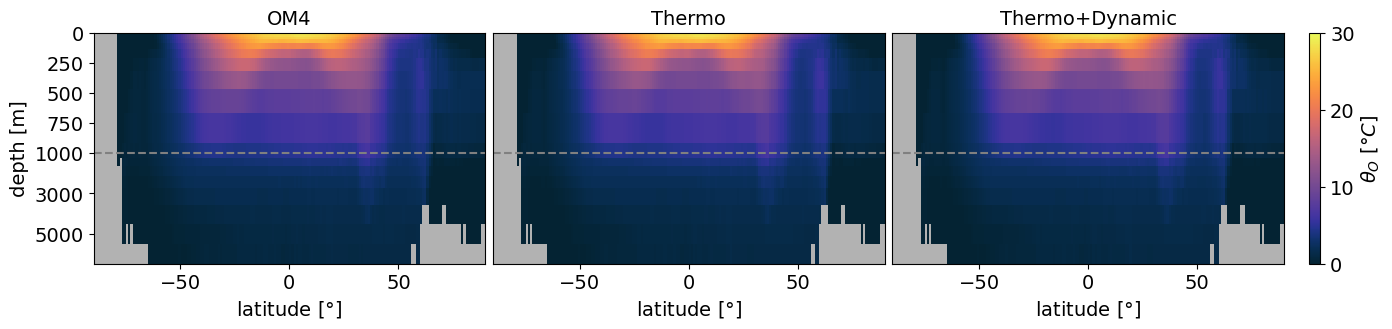

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cmocean as cm

plt.clf()
plt.rcParams.update({'font.size': 14})

# Define colormap
new_cmap = cm.cm.thermal 
new_cmap.set_bad('grey', .6)


num_basins = 1
num_models = len(pred_dict) + 1  # Including OM4

# Create figure with appropriate layout
fig, ax = plt.subplots(num_basins, num_models, figsize=(16, 3), 
                       gridspec_kw={'width_ratios': [1]*num_models, 
                                    'height_ratios': [1]*num_basins, 
                                    'wspace': 0.02, 'hspace': 0.5})
ax = np.array(ax)  # Ensure ax is an array for easy indexing

# Set common color range for the colorbar
vmin, vmax = 0, 30

# Plot OM4 (original data)
da_temp = data['thetao'] # Directly use temperature variable
section_mask = np.isnan(da_temp).all('x').isel(time=0)
da_temp_int_x = da_temp.weighted(data['areacello']).mean(['x', 'time'])
temp_pred = da_temp_int_x.where(~section_mask)
temp_pred = temp_pred.rename(r'$\theta_O$').assign_attrs(units=r'$\degree C$')
temp_pred['y'] = temp_pred.y.assign_attrs(long_name='latitude', units=r'$\degree$')
temp_pred['lev'] = temp_pred.lev.assign_attrs(long_name='depth', units='m')

im = temp_pred.plot(ax=ax[0], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
om4_temp_pred = temp_pred
ax[0].invert_yaxis()
ax[0].set_title("OM4", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[0])
ax[0].axhline(1000, color='0.5', ls='--')
ax[0].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])

# Plot predictions from other models
for j, (model_key, model_data) in enumerate(pred_dict.items(), start=1):
    da_temp = model_data["ds_prediction"]['thetao']  # Use temperature variable
    section_mask = np.isnan(da_temp).all('x').isel(time=0)
    da_temp_int_x = da_temp.weighted(data['areacello']).mean(['x', 'time'])
    temp_pred = da_temp_int_x.where(~section_mask)
    temp_pred = temp_pred.rename(r'$\theta_O$').assign_attrs(units=r'$\degree C$')
    temp_pred['y'] = temp_pred.y.assign_attrs(long_name='latitude', units=r'$\degree$')
    temp_pred['lev'] = temp_pred.lev.assign_attrs(long_name='depth', units='m')
    pred_dict[model_key]['temp_profile'] = temp_pred

    im = temp_pred.plot(ax=ax[j], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    ax[j].invert_yaxis()
    ax[j].set_title(f"{pred_dict[model_key]['name']}", fontsize=14)
    linear_piecewise_scale(1000, 5, ax=ax[j])
    ax[j].axhline(1000, color='0.5', ls='--')
    # ax[j].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
    ax[j].set_yticks([])
    ax[j].set_ylabel("")

# Add shared colorbar for each row
cbar = fig.colorbar(im, ax=ax[:], orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r"$\theta_O$ [$\degree C$]")

# plt.show()
plt.savefig(os.path.join(output_path, "Temperature_Global_Profile"), bbox_inches='tight', dpi=600)

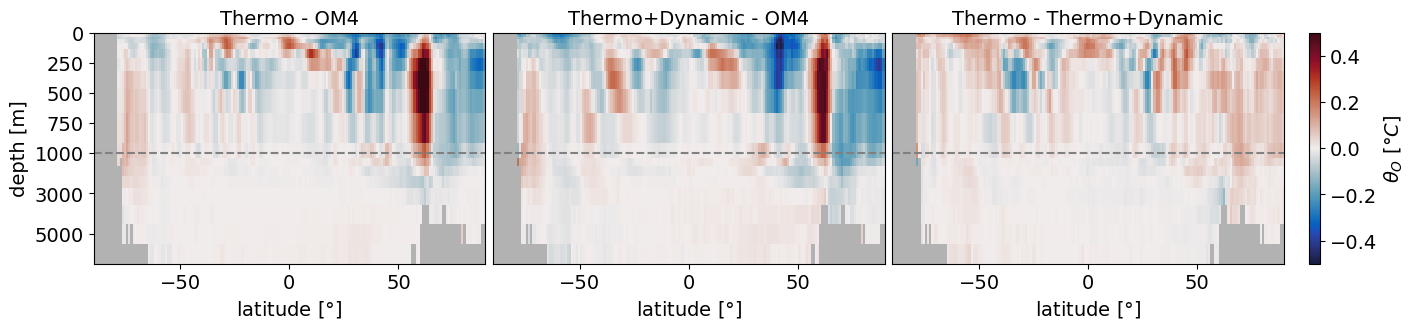

In [14]:
new_cmap = cm.cm.balance 
new_cmap.set_bad('grey', .6)
fig, ax = plt.subplots(1, 3, figsize=(16, 3), gridspec_kw={'width_ratios': [1, 1, 1], 
                                    'height_ratios': [1],
                                    'wspace': 0.02, 'hspace': 0.5})
vmin, vmax = -0.5, 0.5
for i, key in enumerate(pred_dict):
    im = (pred_dict[key]['temp_profile']-om4_temp_pred).plot(ax=ax[i], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    ax[i].invert_yaxis()
    ax[i].set_title(f"{pred_dict[key]['name']} - OM4", fontsize=14)
    linear_piecewise_scale(1000, 5, ax=ax[i])
    ax[i].axhline(1000, color='0.5', ls='--')
    if i == 0:
        ax[i].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
    else:
        ax[i].set_yticks([])
        ax[i].set_ylabel("")

i=i+1
im = (pred_dict['pred_1']['temp_profile']-pred_dict['pred_2']['temp_profile']).plot(ax=ax[i], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
ax[i].invert_yaxis()
ax[i].set_title(f"{pred_dict['pred_1']['name']} - {pred_dict['pred_2']['name']}", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[i])
ax[i].axhline(1000, color='0.5', ls='--')
ax[i].set_yticks([])
ax[i].set_ylabel("")
cbar = fig.colorbar(im, ax=ax[:], orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r"$\theta_O$ [$\degree C$]")

plt.savefig(os.path.join(output_path, "Temperature_Diff_Global_Profile"), bbox_inches='tight', dpi=600)

<Figure size 640x480 with 0 Axes>

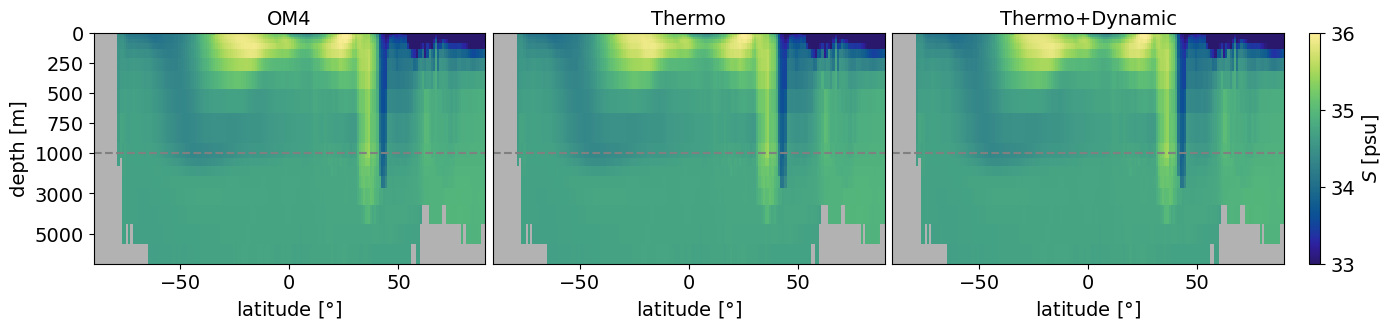

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cmocean as cm

plt.clf()
plt.rcParams.update({'font.size': 14})

# Define colormap
new_cmap = cm.cm.haline  # Salinity-specific colormap from cmocean
new_cmap.set_bad('grey', .6)

num_basins = 1
num_models = len(pred_dict) + 1  # Including OM4

# Create figure with appropriate layout
fig, ax = plt.subplots(num_basins, num_models, figsize=(16, 3), 
                       gridspec_kw={'width_ratios': [1]*num_models, 
                                    'height_ratios': [1]*num_basins, 
                                    'wspace': 0.02, 'hspace': 0.5})
ax = np.array(ax)  # Ensure ax is an array for easy indexing

# Set common color range for the colorbar
vmin, vmax = 33, 36  # Typical salinity range, adjust as needed

# Plot OM4 (original data)
da_salinity = data['so']  # Replace with salinity variable
section_mask = np.isnan(da_salinity).all('x').isel(time=0)
da_salinity_int_x = da_salinity.weighted(data['areacello']).mean(['x', 'time'])
salinity_pred = da_salinity_int_x.where(~section_mask)
salinity_pred = salinity_pred.rename(r'$S$').assign_attrs(units='psu')  # Salinity units
salinity_pred['y'] = salinity_pred.y.assign_attrs(long_name='latitude', units=r'$\degree$')
salinity_pred['lev'] = salinity_pred.lev.assign_attrs(long_name='depth', units='m')

im = salinity_pred.plot(ax=ax[0], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
om4_salinity_pred = salinity_pred
ax[0].invert_yaxis()
ax[0].set_title("OM4", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[0])
ax[0].axhline(1000, color='0.5', ls='--')
ax[0].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])

# Plot predictions from other models
for j, (model_key, model_data) in enumerate(pred_dict.items(), start=1):
    da_salinity = model_data["ds_prediction"]['so']  # Replace with salinity variable
    section_mask = np.isnan(da_salinity).all('x').isel(time=0)
    da_salinity_int_x = da_salinity.weighted(data['areacello']).mean(['x', 'time'])
    salinity_pred = da_salinity_int_x.where(~section_mask)
    salinity_pred = salinity_pred.rename(r'$S$').assign_attrs(units='psu')
    salinity_pred['y'] = salinity_pred.y.assign_attrs(long_name='latitude', units=r'$\degree$')
    salinity_pred['lev'] = salinity_pred.lev.assign_attrs(long_name='depth', units='m')
    pred_dict[model_key]['salinity_profile'] = salinity_pred

    im = salinity_pred.plot(ax=ax[j], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    ax[j].invert_yaxis()
    ax[j].set_title(f"{pred_dict[model_key]['name']}", fontsize=14)
    linear_piecewise_scale(1000, 5, ax=ax[j])
    ax[j].axhline(1000, color='0.5', ls='--')
    if j == 0:
        ax[j].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
    else:
        ax[j].set_yticks([])
        ax[j].set_ylabel("")

# Add shared colorbar for each row
cbar = fig.colorbar(im, ax=ax[:], orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r"$S$ [psu]")  # Salinity colorbar label in psu

# Save the figure
# plt.show()
plt.savefig(os.path.join(output_path, "Salinity_Global_Profile"), bbox_inches='tight', dpi=600)

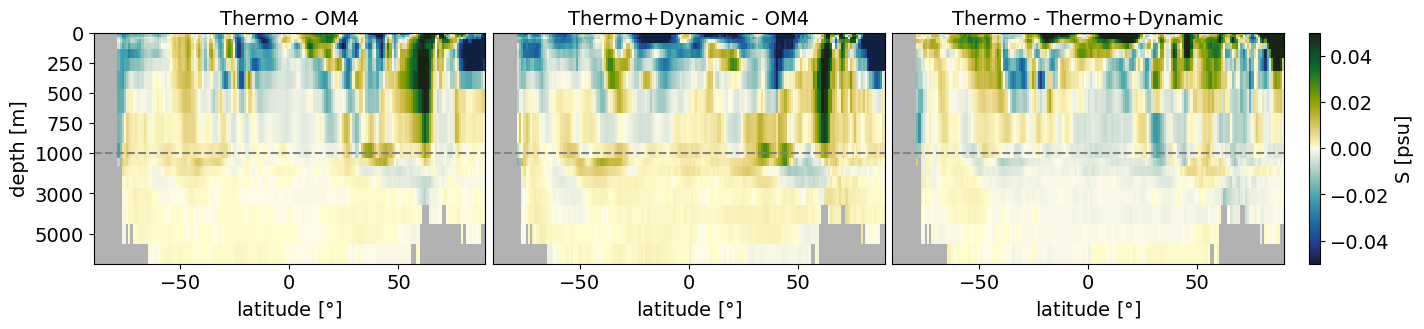

In [16]:
import cmocean as cm
import matplotlib.pyplot as plt
new_cmap = cm.cm.delta 
new_cmap.set_bad('grey', .6)
fig, ax = plt.subplots(1, 3, figsize=(16, 3), gridspec_kw={'width_ratios': [1, 1, 1], 
                                    'height_ratios': [1],
                                    'wspace': 0.02, 'hspace': 0.5})
vmin, vmax = -0.05, 0.05

i = 0

im = (pred_dict['pred_1']['salinity_profile']-om4_salinity_pred).plot(ax=ax[i], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
ax[i].invert_yaxis()
ax[i].set_title(f"{pred_dict['pred_1']['name']} - OM4", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[i])
ax[i].axhline(1000, color='0.5', ls='--')
ax[i].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])

i=i+1
im = (pred_dict['pred_2']['salinity_profile']-om4_salinity_pred).plot(ax=ax[i], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
ax[i].invert_yaxis()
ax[i].set_title(f"{pred_dict['pred_2']['name']} - OM4", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[i])
ax[i].axhline(1000, color='0.5', ls='--')
# ax[i].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
ax[i].set_yticks([])
ax[i].set_ylabel("")

i=i+1
im = (pred_dict['pred_1']['salinity_profile']-pred_dict['pred_2']['salinity_profile']).plot(ax=ax[i], cmap=new_cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
ax[i].invert_yaxis()
ax[i].set_title(f"{pred_dict['pred_1']['name']} - {pred_dict['pred_2']['name']}", fontsize=14)
linear_piecewise_scale(1000, 5, ax=ax[i])
ax[i].axhline(1000, color='0.5', ls='--')
# ax[i].set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
ax[i].set_yticks([])
ax[i].set_ylabel("")

cbar = fig.colorbar(im, ax=ax[:], orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label(r"S [psu]")

plt.savefig(os.path.join(output_path, "Salinity_Diff_Global_Profile"), bbox_inches='tight', dpi=600)

### ENSO

In [17]:
clim =  data['thetao'].sel(lev = slice(0,500)).groupby('time.dayofyear').mean().compute()
data_surface = data.sel(lev = slice(0,500))
for k in pred_dict.keys():
    pred_dict[k]["ds_prediction_surface"] = pred_dict[k]["ds_prediction"].sel(lev = slice(0,500))
    pred_dict[k]["clim_pred"] = pred_dict[k]["ds_prediction_surface"]['thetao'].groupby('time.dayofyear').mean().compute()

In [18]:
def NinoIndexComputeClim(T,area,dt = 5, window = 150):
    T = T.load()
    T_clim = T.copy()
    T_clim = T_clim.sel(x = slice(190,240), y = slice(-5,5))
    area = area.sel(x = slice(190,240), y = slice(-5,5)).load()
    clim = T_clim.groupby('time.dayofyear').mean('time').compute()
    window = int(window/dt)
    for i, t in enumerate(T_clim.time.values):
        day = int(t.dayofyr)
        T_clim[i] = (T[i]-clim.sel(dayofyear=day)).data        

    T_clim = T_clim.rolling(time = window).mean()
    # T_clim = (T_clim*area).sum(["x","y"])/area.sum(["x","y"])
    T_clim = T_clim.weighted(area).mean(["x", "y"])

    return T_clim[window:]


In [19]:
nino_true_compute_clim = NinoIndexComputeClim(data_surface['thetao'][:,0],data['areacello'])
nino_true_compute_clim = nino_true_compute_clim.rename('Nino 3.4')
nino_true_compute_clim = nino_true_compute_clim.assign_attrs(units = r'$\degree C$')

for k in pred_dict.keys():
    pred_dict[k]["nino_pred_compute_clim"] = NinoIndexComputeClim(pred_dict[k]["ds_prediction_surface"]['thetao'][:,0],pred_dict[k]["ds_prediction"]['areacello'])
    pred_dict[k]["nino_pred_compute_clim"] = pred_dict[k]["nino_pred_compute_clim"].rename('Nino 3.4')
    nino_pred_compute_clim = pred_dict[k]["nino_pred_compute_clim"].assign_attrs(units = r'$\degree C$')

In [20]:
import numpy as np
day_max = int((np.argwhere(nino_true_compute_clim.values == np.nanmax(nino_true_compute_clim.values)) + 30).squeeze())
day_min = int((np.argwhere(nino_true_compute_clim.values == np.nanmin(nino_true_compute_clim.values)) + 30).squeeze())

### Maps

This works for two predictions only

In [21]:
keys = list(pred_dict.keys())
# assert len(keys) >= 2, "Maps supported by atleast two keys"
if len(keys) != 2:
    print("Maps only support two models for now!!! Using the first two keys")
key1 = keys[0]
key2 = keys[1]

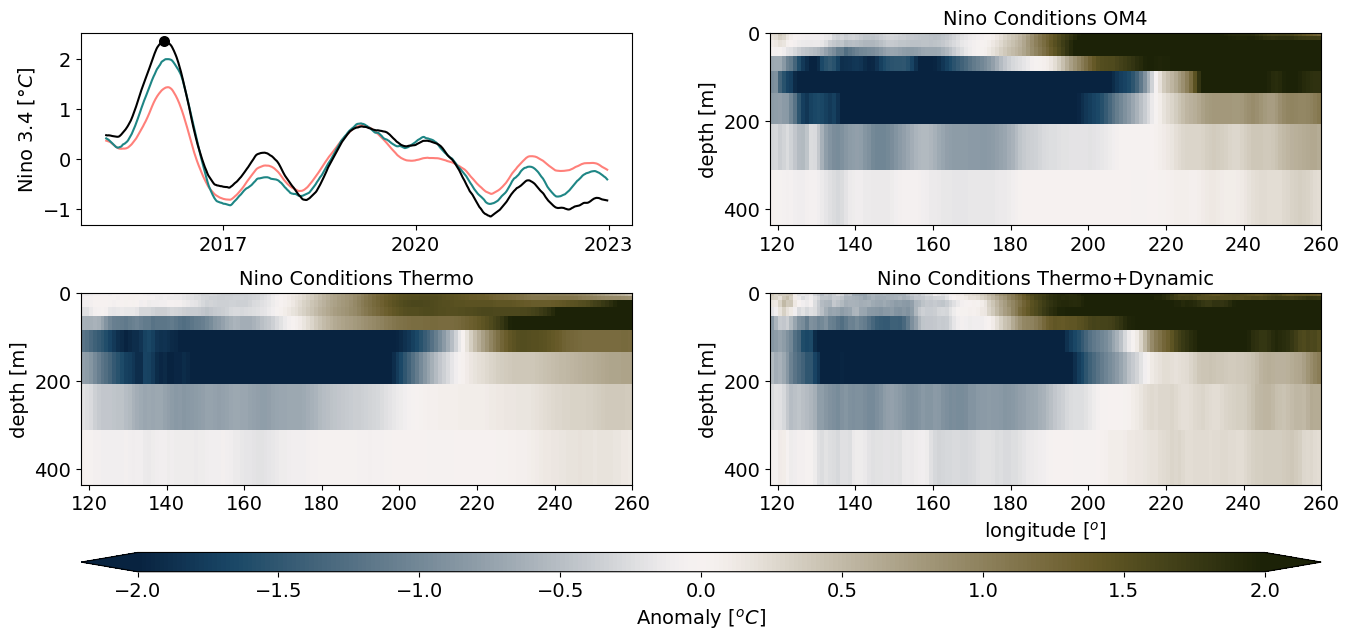

In [22]:
from xarrayutils.plotting import box_plot
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplot_mosaic([['time series','nino_true'],['nino_pred','nino_pred_temp'],['colorbar','colorbar']],figsize = (16,7),gridspec_kw={'width_ratios': [1,1], 'height_ratios': [.5,.5,.05], 'wspace': 0.25,'hspace':.5})

pred_dict[key1]["nino_pred_compute_clim"].plot(label = pred_dict[key1]["name"], c = clist[0],ax = axs['time series'])
pred_dict[key2]["nino_pred_compute_clim"].plot(label = pred_dict[key2]["name"], c = clist[1],ax = axs['time series'])

nino_true_compute_clim.plot(label = 'OM4', c = 'k',ax = axs['time series'])
nino_true_compute_clim.isel(time = slice(day_max-30,day_max-30+1)).drop_vars(['dz','lev']).plot.scatter(s = 80, c = 'k',ax = axs['time series'])
# nino_true_compute_clim.isel(time = slice(day_min-30,day_min-30+1)).drop_vars(['dz','lev']).plot.scatter(s = 80, c = 'k',ax = axs['time series'])

axs['time series'].set_title('')
axs['time series'].set_xlabel('')
# axs['time series'].legend()
# axs['time series'].set_title('Nino 3.4 Index')

day_start = day_max
window = 3

time_slice = slice(pred_dict[key2]["ds_prediction_surface"]['time'][day_start],pred_dict[key2]["ds_prediction_surface"]['time'][day_start+window])
times = pred_dict[key2]["ds_prediction"]['time'][day_start:day_start+window].data
days_of_year = [i.dayofyr for i in times]
true_clim_to_remove = clim.sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
true_clim_to_remove['time'] = times
pred_clim_to_remove = pred_dict[key1]["clim_pred"].sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
pred_clim_to_remove['time'] = times
pred_clim_to_remove_temp = pred_dict[key2]["clim_pred"].sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
pred_clim_to_remove_temp['time'] = times

tropics_profile = (data_surface['thetao'].sel(time = time_slice,x = slice(118,260), y = slice(-5,5))-true_clim_to_remove.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile_pred = (pred_dict[key1]["ds_prediction_surface"]['thetao'][day_start:day_start+window].sel(lev = slice(0,500),x = slice(118,260), y = slice(-5,5))-pred_clim_to_remove.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile_pred_temp = (pred_dict[key2]["ds_prediction_surface"]['thetao'][day_start:day_start+window].sel(lev = slice(0,500),x = slice(118,260), y = slice(-5,5))-pred_clim_to_remove_temp.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile = tropics_profile.rename('Anomaly')
tropics_profile_pred = tropics_profile_pred.rename('Anomaly')
tropics_profile_pred_temp = tropics_profile_pred_temp.rename('Anomaly')
tropics_profile = tropics_profile.assign_attrs(units = r"${^oC}$")
tropics_profile_pred = tropics_profile_pred.assign_attrs(units = r"${^oC}$")
tropics_profile_pred_temp = tropics_profile_pred_temp.assign_attrs(units = r"${^oC}$")
tropics_profile_pred_temp['x'] = tropics_profile_pred_temp['x'].assign_attrs(units = r"${^o}$")

tropics_profile.plot.pcolormesh(ax = axs['nino_true'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,add_colorbar = False)
axs['nino_true'].set_title('Nino Conditions OM4', fontsize=14)
axs['nino_true'].set_xlabel('')
axs['nino_true'].invert_yaxis()
tropics_profile_pred.plot.pcolormesh(ax = axs['nino_pred'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,add_colorbar = False)
axs['nino_pred'].set_title(f'Nino Conditions {pred_dict[key1]["name"]}', fontsize=14)
axs['nino_pred'].set_xlabel('')
axs['nino_pred'].invert_yaxis()
tropics_profile_pred_temp.plot.pcolormesh(ax = axs['nino_pred_temp'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,cbar_ax=axs['colorbar'],cbar_kwargs={
                        "orientation": "horizontal",
                        "shrink": 0.3,
                        "extend": "both",
                    })
axs['nino_pred_temp'].set_title(f'Nino Conditions {pred_dict[key2]["name"]}', fontsize=14)
# axs['nino_pred_temp'].set_xlabel('')
axs['nino_pred_temp'].invert_yaxis()

plt.savefig(os.path.join(output_path, "Nino_Figure_Short_without_map.png"), bbox_inches='tight', dpi=600)


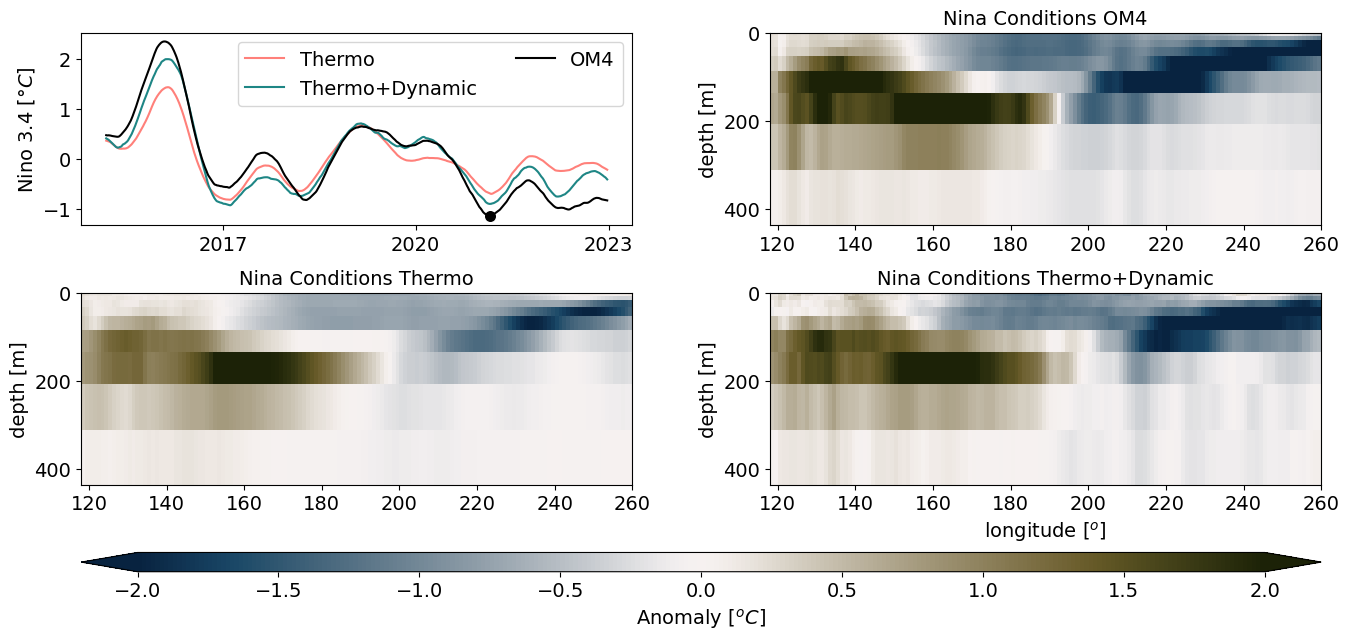

In [23]:
from xarrayutils.plotting import box_plot
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplot_mosaic([['time series','nina_true'],['nina_pred','nina_pred_temp'],['colorbar','colorbar']],figsize = (16,7),gridspec_kw={'width_ratios': [1,1], 'height_ratios': [.5,.5,.05], 'wspace': 0.25,'hspace':.5})

pred_dict[key1]["nino_pred_compute_clim"].plot(label = pred_dict[key1]["name"], c = clist[0],ax = axs['time series'])
pred_dict[key2]["nino_pred_compute_clim"].plot(label = pred_dict[key2]["name"], c = clist[1],ax = axs['time series'])

nino_true_compute_clim.plot(label = 'OM4', c = 'k',ax = axs['time series'])
# nino_true_compute_clim.isel(time = slice(day_max-30,day_max-30+1)).drop_vars(['dz','lev']).plot.scatter(s = 80, c = 'k',ax = axs['time series'])
nino_true_compute_clim.isel(time = slice(day_min-30,day_min-30+1)).drop_vars(['dz','lev']).plot.scatter(s = 80, c = 'k',ax = axs['time series'])

axs['time series'].set_title('')
axs['time series'].set_xlabel('')
axs['time series'].legend(ncol=2)
# axs['time series'].set_title('Nino 3.4 Index')


day_start = day_min
window = 3

time_slice = slice(pred_dict[key2]["ds_prediction"]['time'][day_start],pred_dict[key2]["ds_prediction"]['time'][day_start+window])
times = pred_dict[key2]["ds_prediction"]['time'][day_start:day_start+window].data
days_of_year = [i.dayofyr for i in times]
true_clim_to_remove = clim.sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
true_clim_to_remove['time'] = times
pred_clim_to_remove = pred_dict[key1]["clim_pred"].sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
pred_clim_to_remove['time'] = times
pred_clim_to_remove_temp = pred_dict[key2]["clim_pred"].sel(dayofyear = days_of_year).rename({'dayofyear': 'time'})
pred_clim_to_remove_temp['time'] = times

tropics_profile = (data_surface['thetao'].sel(time = time_slice,x = slice(118,260), y = slice(-5,5))-true_clim_to_remove.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile_pred = (pred_dict[key1]["ds_prediction_surface"]['thetao'][day_start:day_start+window].sel(lev = slice(0,500),x = slice(118,260), y = slice(-5,5))-pred_clim_to_remove.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile_pred_temp = (pred_dict[key2]["ds_prediction_surface"]['thetao'][day_start:day_start+window].sel(lev = slice(0,500),x = slice(118,260), y = slice(-5,5))-pred_clim_to_remove_temp.sel(x = slice(118,260), y = slice(-5,5))).mean(['time','y'])
tropics_profile = tropics_profile.rename('Anomaly')
tropics_profile_pred = tropics_profile_pred.rename('Anomaly')
tropics_profile_pred_temp = tropics_profile_pred_temp.rename('Anomaly')
tropics_profile = tropics_profile.assign_attrs(units = r"${^oC}$")
tropics_profile_pred = tropics_profile_pred.assign_attrs(units = r"${^oC}$")
tropics_profile_pred_temp = tropics_profile_pred_temp.assign_attrs(units = r"${^oC}$")
tropics_profile_pred_temp['x'] = tropics_profile_pred_temp['x'].assign_attrs(units = r"${^o}$")

tropics_profile.plot.pcolormesh(ax = axs['nina_true'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,add_colorbar = False)
axs['nina_true'].set_title('Nina Conditions OM4', fontsize=14)
axs['nina_true'].set_xlabel('')
axs['nina_true'].invert_yaxis()
tropics_profile_pred.plot.pcolormesh(ax = axs['nina_pred'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,add_colorbar = False)
axs['nina_pred'].set_title(f'Nina Conditions {pred_dict[key1]["name"]}', fontsize=14)
axs['nina_pred'].set_xlabel('')
axs['nina_pred'].invert_yaxis()
tropics_profile_pred_temp.plot.pcolormesh(ax = axs['nina_pred_temp'],y = 'lev',cmap = cm.cm.diff,vmin = -2,vmax = 2,cbar_ax=axs['colorbar'],cbar_kwargs={
                        "orientation": "horizontal",
                        "shrink": 0.3,
                        "extend": "both",
                    })
axs['nina_pred_temp'].set_title(f'Nina Conditions {pred_dict[key2]["name"]}', fontsize=14)
# axs['nina_pred_temp'].set_xlabel('')
axs['nina_pred_temp'].invert_yaxis()


plt.savefig(os.path.join(output_path, "Nina_Figure_Short_without_map.png"), bbox_inches='tight', dpi=600)


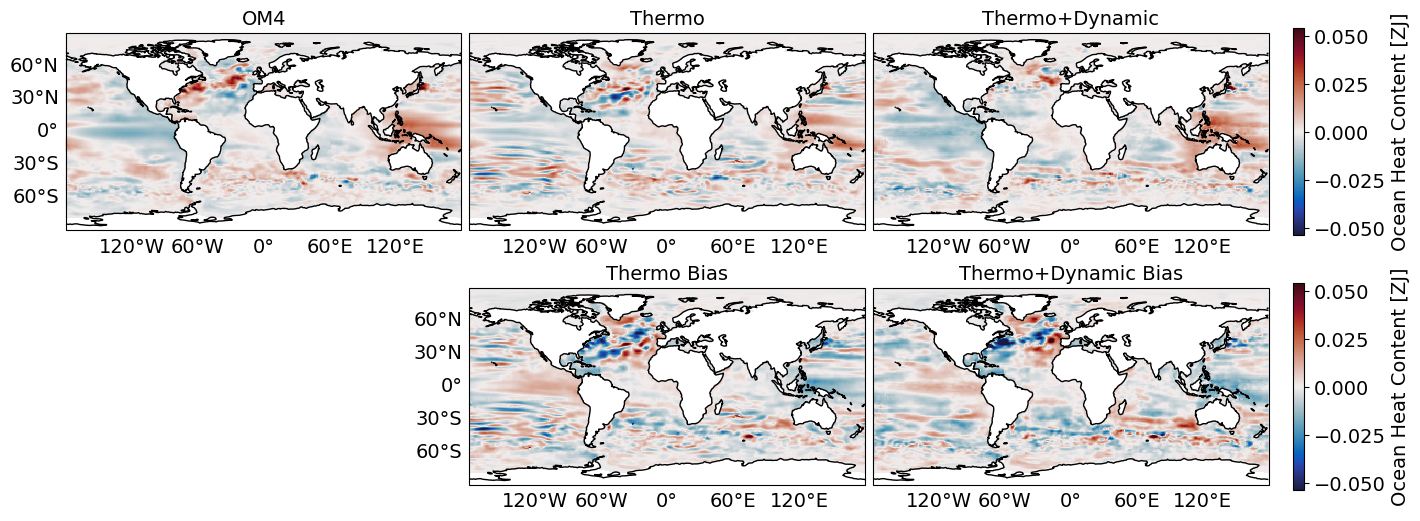

In [24]:
# OHC Map + Bias
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FixedLocator


Days_to_Eq = 0
c_p = 3850  # J/(kg C)
rho_0 = 1025  # kg/m^3
zeta_joules_factor = 1e21  # Conversion factor to ZJ

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2, 3, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'wspace': 0.02, 'hspace': 0.23})
axs = axs.flatten()

def ohc_map(ohc_intz):
    # return last 1 year - first 1 year
    return ohc_intz.isel(time=slice(-73, None)).mean('time')-ohc_intz.isel(time=slice(0, 73)).mean('time')

# Define a common plotting function for Cartesian lat-lon grids
def plot_ohc(ax, ohc_data, title, i):
    # Configure colormap and set color for NaN values (land)
    colormap = cmocean.cm.balance # cmocean.cm.thermal  # Using thermal colormap from cmocean
    colormap.set_bad(color=(0.7, 0.7, 0.7, 0)) 
    mean = ohc_data.mean().compute().item()
    std = ohc_data.std().compute().item()
    vmin = mean-8*std
    vmax = mean+8*std
    im = ax.pcolormesh(
        ohc_data['x'], ohc_data['y'], ohc_data,
        shading='auto', cmap=colormap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax
    )
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_title(title, fontsize=14)
    # Set longitude and latitude labels
    gl = ax.gridlines(draw_labels=True, color='0.4', linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    gl.xlocator = FixedLocator([-120, -60, 0, 60, 120])

    if i > 0:
        gl.left_labels = False
    return im

def plot_diff_ohc(ax, ohc_data, gt_ohc_data, title, i):
    # Configure colormap and set color for NaN values (land)
    colormap = cmocean.cm.balance  # Using thermal colormap from cmocean
    colormap.set_bad(color=(0.7, 0.7, 0.7, 0)) 
    bias_ohc = ohc_data - gt_ohc_data
    mean = ohc_data.mean().compute().item()
    std = ohc_data.std().compute().item()
    vmin = mean-8*std
    vmax = mean+8*std
    im = ax.pcolormesh(
        bias_ohc['x'], bias_ohc['y'], bias_ohc,
        shading='auto', cmap=colormap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax
    )
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_title(title, fontsize=14)
    # Set longitude and latitude labels
    gl = ax.gridlines(draw_labels=True, color='0.4', linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    gl.xlocator = FixedLocator([-120, -60, 0, 60, 120])

    if i > 4:
        gl.left_labels = False
    return im

# Calculate Ocean Heat Content for different scenarios and convert to Zeta Joules
titles = ["OM4", pred_dict[key1]["name"], pred_dict[key2]["name"]]
bias_titles = [pred_dict[key1]["name"] + " Bias", pred_dict[key2]["name"] + " Bias"]
datasets = [data, pred_dict[key1]["ds_prediction"], pred_dict[key2]["ds_prediction"]]

for i, (ax, title, ds) in enumerate(zip(axs, titles, datasets)):
    section_mask = np.isnan(ds['thetao']).all('lev').isel(time=5)
    OHC_pred = (
        (ds['thetao'][Days_to_Eq:] * c_p * rho_0 / zeta_joules_factor)
        .weighted(ds['areacello'] * ds['dz']).sum(['lev'])
        .compute() 
    )
    OHC_pred = ohc_map(OHC_pred)
    OHC_pred = OHC_pred.where(~section_mask)
    OHC_pred = OHC_pred.rename('Ocean Heat Content')
    OHC_pred['y'] = OHC_pred.y.assign_attrs(long_name='latitude', units=r"${^o}$")
    OHC_pred['x'] = OHC_pred.x.assign_attrs(long_name='longitude', units=r"${^o}$")
    OHC_pred = OHC_pred.assign_attrs(units='ZJ')
    
    
    if i == 0:
        gt_ohc = OHC_pred
    elif i == 1:
        pred1_ohc = OHC_pred
    elif i == 2:
        pred2_ohc = OHC_pred

    # Plot using the Cartesian lat-lon grid
    im = plot_ohc(ax, OHC_pred, title, i)

# Add colorbar
cbar = fig.colorbar(im, ax=axs[:3], orientation='vertical', fraction=0.01, pad=0.02)
cbar.set_label("Ocean Heat Content [ZJ]", fontsize=14)

im = plot_diff_ohc(axs[4], pred1_ohc, gt_ohc, bias_titles[0], 4)
im = plot_diff_ohc(axs[5], pred2_ohc, gt_ohc, bias_titles[1], 5)

# Add colorbar
cbar = fig.colorbar(im, ax=axs[3:], orientation='vertical', fraction=0.01, pad=0.02)
cbar.set_label("Ocean Heat Content [ZJ]", fontsize=14)

fig.delaxes(axs[3])

# Save or display the plot
plt.savefig(os.path.join(output_path, "OHC_Global_map.png"), bbox_inches='tight', dpi=600)
# plt.show()

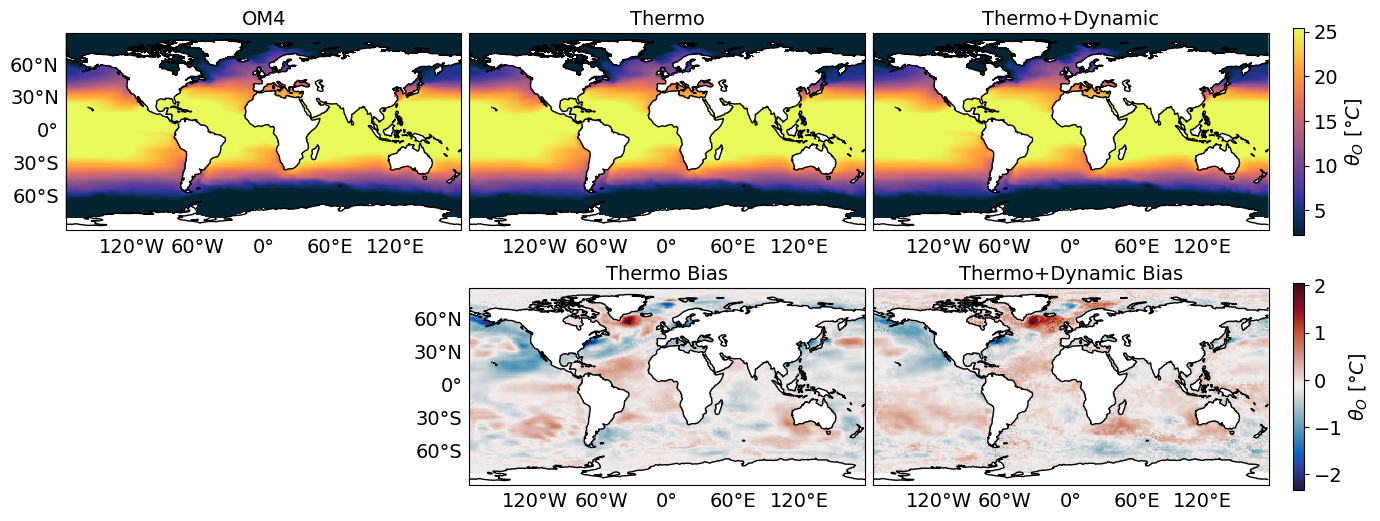

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FixedLocator


Days_to_Eq = 0
plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(2, 3, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'wspace': 0.02, 'hspace': 0.23})
axs = axs.flatten()

# Define a common plotting function for Cartesian lat-lon grids
def plot_sst(ax, sst_data, title, i):
    colormap = cmocean.cm.thermal
    colormap.set_bad(color=(0.7, 0.7, 0.7, 0)) 
    mean = sst_data.mean().compute().item()
    std = sst_data.std().compute().item()
    vmin = mean-std
    vmax = mean+std
    im = ax.pcolormesh(
        sst_data['x'], sst_data['y'], sst_data,
        shading='auto', cmap=colormap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax
    )
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_title(title, fontsize=14)
    gl = ax.gridlines(draw_labels=True, color='0.4', linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    gl.xlocator = FixedLocator([-120, -60, 0, 60, 120])

    if i > 0:
        gl.left_labels = False
    return im

def plot_diff_sst(ax, sst_data, gt_sst_data, title, i):
    colormap = cmocean.cm.balance
    colormap.set_bad(color=(0.7, 0.7, 0.7, 0)) 
    sst_bias = sst_data - gt_sst_data
    im = ax.pcolormesh(
        sst_bias['x'], sst_bias['y'], sst_bias,
        shading='auto', cmap=colormap, transform=ccrs.PlateCarree()
    )
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_title(title, fontsize=14)
    gl = ax.gridlines(draw_labels=True, color='0.4', linestyle='--', alpha=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    gl.xlocator = FixedLocator([-120, -60, 0, 60, 120])

    if i > 4:
        gl.left_labels = False
    return im

# Calculate Sea Surface Temperature (SST) for different scenarios
titles = ["OM4", pred_dict[key1]["name"], pred_dict[key2]["name"]]
bias_titles = [pred_dict[key1]["name"] + " Bias", pred_dict[key2]["name"] + " Bias"]
datasets = [data, pred_dict[key1]["ds_prediction"], pred_dict[key2]["ds_prediction"]]

for i, (ax, title, ds) in enumerate(zip(axs, titles, datasets)):
    section_mask = np.isnan(ds['thetao']).isel(lev=0).isel(time=5)
    SST_pred = ds['thetao'].isel(lev=0).mean('time')
    SST_pred = SST_pred.where(~section_mask)
    SST_pred = SST_pred.rename("2.5m "+r'$\theta_O$')
    SST_pred['y'] = SST_pred.y.assign_attrs(long_name='latitude', units=r"${^o}$")
    SST_pred['x'] = SST_pred.x.assign_attrs(long_name='longitude', units=r"${^o}$")
    SST_pred = SST_pred.assign_attrs(units=r'$\degree C$')
    
    if i == 0:
        gt_sst = SST_pred
    elif i == 1:
        pred1_sst = SST_pred
    elif i == 2:
        pred2_sst = SST_pred

    # Plot using the Cartesian lat-lon grid
    im = plot_sst(ax, SST_pred, title, i)

# Add colorbar for SST plots
cbar = fig.colorbar(im, ax=axs[:3], orientation='vertical', fraction=0.01, pad=0.02)
cbar.set_label(r'$\theta_O$ [$\degree C$]', fontsize=14)

# Plot biases for SST
im = plot_diff_sst(axs[4], pred1_sst, gt_sst, bias_titles[0], 4)
im = plot_diff_sst(axs[5], pred2_sst, gt_sst, bias_titles[1], 5)

# Add colorbar for bias plots
cbar = fig.colorbar(im, ax=axs[3:], orientation='vertical', fraction=0.01, pad=0.02)
cbar.set_label(r'$\theta_O$ [$\degree C$]', fontsize=14)

# Remove the empty axis
fig.delaxes(axs[3])

# Save or display the plot
plt.savefig(os.path.join(output_path, "SST_Global_map.png"), bbox_inches='tight', dpi=600)
# plt.show()